# Integrative Assay Summary

In [1]:
import sys
import polars as pl
import pandas as pd
import numpy as np
# Create heatmap with custom colors
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedFormatter, FixedLocator
import matplotlib as mpl
from matplotlib.patches import Patch
import matplotlib.font_manager as fm
from scipy.stats import fisher_exact, mannwhitneyu
from matplotlib.gridspec import GridSpec
from statannotations.Annotator import Annotator

# Force TrueType font embedding (Type 42)
# mpl.rcParams['pdf.fonttype'] = 42
# mpl.rcParams['ps.fonttype'] = 42
# Force TrueType font embedding (Type 42)
mpl.rcParams['svg.fonttype'] = 'none'  # keep text as text
# optional: make sure LaTeX text is OFF, or it will often become paths
mpl.rcParams['text.usetex'] = False

# Verify settings
# print(f"pdf.fonttype: {mpl.rcParams['pdf.fonttype']}")
# print(f"ps.fonttype: {mpl.rcParams['ps.fonttype']}")
# print(f"font.family: {mpl.rcParams['font.family']}")

font_path = "../../utils/ARIAL.TTF"
fm.fontManager.addfont(font_path)

font_prop = fm.FontProperties(fname=font_path)
# Set font family to one of the accepted fonts
plt.rcParams.update({
    "font.family": font_prop.get_name(),
    "font.sans-serif": ["ARIAL"],
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
})

sys.path.append("../../utils")
from utils import *

## 1. Loading data

In [2]:
al_dual_img_ppi_assayed_dedup = pl.read_csv(
    "../1_inputs/0_all_gene_variants_assayed_summary.tsv",
    separator="\t", infer_schema_length=100000
)

print(
    al_dual_img_ppi_assayed_dedup.group_by("clinvar_clnsig_clean_pp_strict").agg(
        pl.len().alias("n_variants"),
    ).sort("n_variants", descending=True)
)

print(
    al_dual_img_ppi_assayed_dedup.with_columns(
    pl.sum_horizontal(
        [
            pl.col("ppi_score").is_not_null(),
            pl.col("dualipa_score").is_not_null(),
            pl.col("imaging_score").is_not_null(),
        ]
    ).alias("assay_tested")
).select(
    ["gene_variant","assay_tested"]
).group_by(
    "assay_tested"
).agg(pl.len()).sort("assay_tested")
)

shape: (7, 2)
┌────────────────────────────────┬────────────┐
│ clinvar_clnsig_clean_pp_strict ┆ n_variants │
│ ---                            ┆ ---        │
│ str                            ┆ u32        │
╞════════════════════════════════╪════════════╡
│ Pathogenic                     ┆ 415        │
│ Likely pathogenic              ┆ 264        │
│ Conflicting                    ┆ 239        │
│ VUS                            ┆ 213        │
│ Others                         ┆ 134        │
│ Likely benign                  ┆ 96         │
│ Benign                         ┆ 66         │
└────────────────────────────────┴────────────┘
shape: (3, 2)
┌──────────────┬─────┐
│ assay_tested ┆ len │
│ ---          ┆ --- │
│ u32          ┆ u32 │
╞══════════════╪═════╡
│ 1            ┆ 889 │
│ 2            ┆ 387 │
│ 3            ┆ 151 │
└──────────────┴─────┘


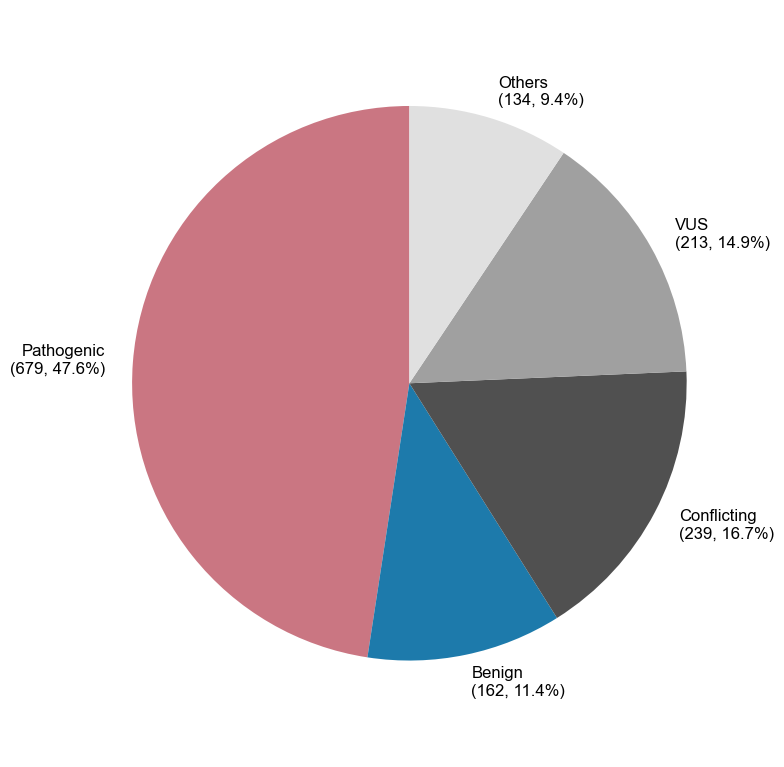

In [3]:
# Create pie chart for ClinVar annotation categories
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# Get the category counts from the merged data
summary_clin_var_counts = al_dual_img_ppi_assayed_dedup.group_by("clinvar_clnsig_clean").agg(pl.len()).to_pandas()
summary_clin_var_counts['clinvar_clnsig_clean'] = pd.Categorical(
    summary_clin_var_counts['clinvar_clnsig_clean'], 
    categories=[c for c in clinvar_order_dict["original"] if "Likely" not in c], 
    ordered=True
)

# Convert to pandas for easier plotting
pie_data = summary_clin_var_counts.sort_values('clinvar_clnsig_clean')

# Calculate percentages
total_count = pie_data["len"].sum()
pie_data["percentage"] = (pie_data["len"] / total_count * 100).round(1)

# Create labels with counts and percentages
labels = [f"{cat}\n({count}, {pct}%)" for cat, count, pct in zip(pie_data["clinvar_clnsig_clean"], 
                                                                 pie_data["len"], 
                                                                 pie_data["percentage"])
]
colors = [palette_dict["clinvar_clnsig_clean"][cat] for cat in pie_data["clinvar_clnsig_clean"]]
# Create pie chart
wedges, texts, autotexts = ax.pie(pie_data["len"], 
                                  labels=labels, 
                                  colors=colors,
                                  autopct="",  # We're including percentages in labels
                                  startangle=90,
                                  counterclock=True,
                                  textprops={'fontsize': 12})

# ax.set_title("Distribution of ClinVar Annotation Categories", fontsize=14, fontweight='bold', pad=20)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# # Add a legend
# ax.legend(wedges, [f"{cat} (n={count})" for cat, count in zip(pie_data["clinvar_clnsig_clean"], pie_data["len"])],
#           title="Categories",
#           loc="center left",
#           bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
plt.show()

# Print summary statistics

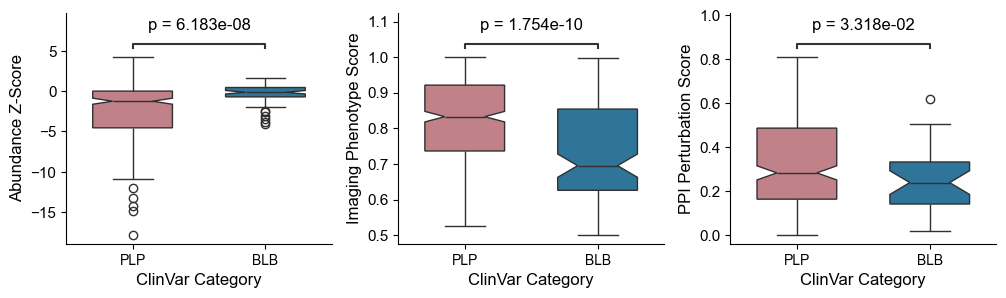

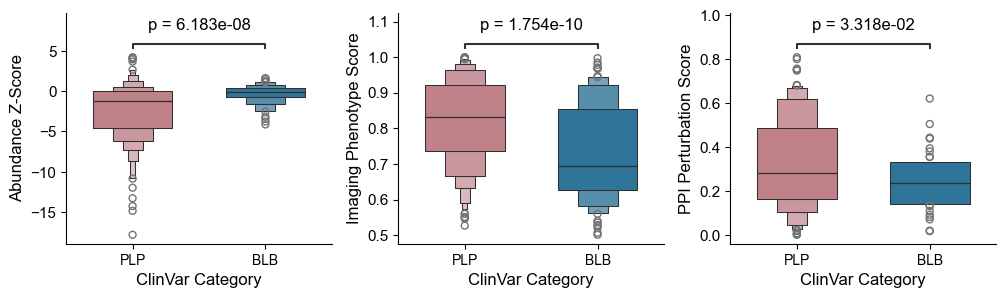

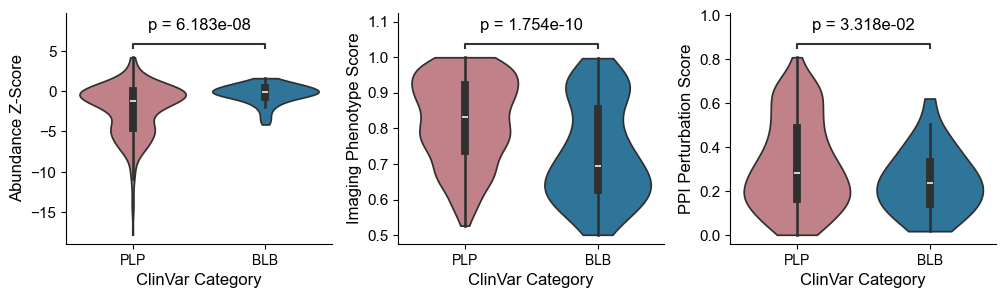

In [16]:
def plot_assay_scores(df, plot_type="box"):
    assays = ["dualipa_score", "imaging_score", "ppi_score"]
    ylabels = ["Abundance Z-Score", "Imaging Phenotype Score", "PPI Perturbation Score"]
    
    # Pathogenic vs Benign: 'less' means Pathogenic < Benign, 'greater' means Pathogenic > Benign
    tests = ["Mann-Whitney-ls", "Mann-Whitney-gt", "Mann-Whitney-gt"]
    
    categories = ["Pathogenic", "Benign"]
    order = [c for c in clinvar_order_dict["original"] if "Likely" not in c]
    
    # Filter once
    plot_df = df.filter(
        pl.col("clinvar_clnsig_clean").is_in(categories)
    ).to_pandas()
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    plot_func = {"box": sns.boxplot, "boxen": sns.boxenplot, "violin": sns.violinplot}[plot_type]
    plot_kw = dict(
        x="clinvar_clnsig_clean",
        hue="clinvar_clnsig_clean",
        palette=palette_dict["clinvar_clnsig_clean"],
        order=order,
        legend=False
    )
    if plot_type == "box":
        plot_kw.update(width=0.6, notch=True)
    elif plot_type == "boxen":
        plot_kw.update(width=0.6)
    elif plot_type == "violin":
        plot_kw.update(cut=0)
    
    for i, (assay, ylabel, test) in enumerate(zip(assays, ylabels, tests)):
        ax = axes[i]
        assay_df = plot_df[plot_df[assay].notna()]
        
        plot_func(data=assay_df, y=assay, ax=ax, **plot_kw)
        annotator = Annotator(
            ax,
            [("Pathogenic", "Benign")],
            data=assay_df,
            x="clinvar_clnsig_clean",
            y=assay,
            hue="clinvar_clnsig_clean",
            order=categories,  # ["Pathogenic", "Benign"] instead of `order`
            verbose=False
        )
        annotator.configure(
            test=test,
            test_short_name="MWU",
            text_format="full",
            show_test_name=False,
            loc="inside",
            text_offset=8,
            # pvalue_thresholds=[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]],
            verbose=False
        )
        annotator.apply_test()
        annotator.annotate(line_offset_to_group=0.05, line_offset=0.15)
        
        ax.set_xlim(-0.5, 1.5)
        ax.xaxis.set_major_locator(FixedLocator(range(2)))
        ax.set_xticklabels(["PLP", "BLB"], fontsize=10)
        ax.set_xlabel("ClinVar Category")
        ax.set_ylabel(ylabel)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    plt.subplots_adjust(wspace=0.25)
    fig.savefig(
        f"../3_outputs/pillar_manuscript_figures/assay_phenotyping_score_{plot_type}_dist_clinvar.svg",
        format="svg", dpi=400, bbox_inches="tight", transparent=True
    )
    plt.show()

for t in ["box", "boxen", "violin"]:
    plot_assay_scores(al_dual_img_ppi_assayed_dedup, t)

## 2. Plot Gene-level Summary per Assay

In [11]:
def explained_gene_per_assay(assay_df, show_plot=False, benign_thres=1e-3, pathogenic_thres=1e-3, palette_name="clinvar_clnsig_clean"):
    """
    Analyze gene-level performance in functional assays with classification.

    Returns all genes with hit percentages and classification based on thresholds.
    """
    df = plot_gene_level_summary(
        assay_df,
        assay="assay_hit",
        cat="clinvar_clnsig_clean",
        plot=show_plot,
        palette=palette_dict[palette_name]
    ).to_pandas()

    # Create pivot table to get hit percentages by gene and clinvar category
    # display(df)
    gene_summary = df.pivot(index='symbol', columns='clinvar_clnsig_clean', values='hit_perc').fillna(0)
    
    # Get benign and pathogenic columns (if they exist)
    benign_col = 'Benign' if 'Benign' in gene_summary.columns else None
    pathogenic_col = 'Pathogenic' if 'Pathogenic' in gene_summary.columns else None

    # Add classification column based on criteria
    def classify_gene(row):
        benign_rate = row[benign_col] if benign_col else float('inf')
        pathogenic_rate = row[pathogenic_col] if pathogenic_col else 0

        # Meets both criteria (low false positive, high true positive)
        if benign_col and pathogenic_col:
            if benign_rate < benign_thres and pathogenic_rate > pathogenic_thres:
                return "High_Discriminatory"
            elif benign_rate >= benign_thres and pathogenic_rate <= pathogenic_thres:
                return "Low_Discriminatory"
            elif benign_rate < benign_thres and pathogenic_rate <= pathogenic_thres:
                return "Low_Sensitivity"
            elif benign_rate >= benign_thres and pathogenic_rate > pathogenic_thres:
                return "High_False_Positive"
            else:
                return "Unclear"
        elif benign_col:
            return "Low_FP" if benign_rate < benign_thres else "High_FP"
        elif pathogenic_col:
            return "High_Sensitivity" if pathogenic_rate > pathogenic_thres else "Low_Sensitivity"
        else:
            return "No_Classification"

    # Add simple pass/fail column
    def passes_threshold(row):
        benign_rate = row[benign_col] if benign_col else float('inf')
        pathogenic_rate = row[pathogenic_col] if pathogenic_col else 0

        if benign_col and pathogenic_col:
            return (benign_rate < benign_thres) and (pathogenic_rate > pathogenic_thres)
        elif benign_col:
            return benign_rate < benign_thres
        elif pathogenic_col:
            return pathogenic_rate > pathogenic_thres
        else:
            return False

    # Apply classification and pass/fail
    gene_summary['Classification'] = gene_summary.apply(classify_gene, axis=1)
    gene_summary['Passes_Threshold'] = gene_summary.apply(passes_threshold, axis=1)

    # Add summary statistics
    gene_summary_with_stats = gene_summary.copy()

    # Count variants by adding total counts from original df
    variant_counts = df.groupby('symbol').agg({
        'total_counts': 'first',
        'total_counts_all': 'first',
        'hit_counts': 'first'
    })
    gene_summary_with_stats = gene_summary_with_stats.join(variant_counts, how='left')

    # --- Fisher's exact test comparing Pathogenic vs Benign hits per gene ---
    # Prepare aggregated counts from df (symbol x clinvar)
    # df has columns: symbol, clinvar_clnsig_clean, total_counts, hit_counts
    fisher_df = None
    agg = df.groupby(['symbol', 'clinvar_clnsig_clean']).agg({
        'hit_counts': 'sum',
        'total_counts': 'sum'
    }).reset_index()

    # iterate genes in gene_summary_with_stats
    records = []
    for gene in gene_summary_with_stats.index:
        sub = agg[agg['symbol'] == gene]
        # pathogenic
        p_row = sub[sub['clinvar_clnsig_clean'] == 'Pathogenic']
        ph = int(p_row['hit_counts'].sum()) if not p_row.empty else 0
        pt = int(p_row['total_counts'].sum()) if not p_row.empty else 0
        # benign
        b_row = sub[sub['clinvar_clnsig_clean'] == 'Benign']
        bh = int(b_row['hit_counts'].sum()) if not b_row.empty else 0
        bt = int(b_row['total_counts'].sum()) if not b_row.empty else 0

        # non-hit counts
        p_non = max(0, pt - ph)
        b_non = max(0, bt - bh)

        odds, pval = np.nan, np.nan
        # require at least one observation in the 2x2 table
        if (pt + bt) > 0:
            try:
                odds, pval = fisher_exact([[ph, p_non], [bh, b_non]], alternative='two-sided')
            except Exception:
                odds, pval = np.nan, np.nan

        records.append({
            'symbol': gene,
            'fisher_oddsratio': odds,
            'fisher_pval': pval,
            'pathogenic_hit': ph,
            'pathogenic_total': pt,
            'pathogenic_nonhit': p_non,
            'benign_hit': bh,
            'benign_total': bt,
            'benign_nonhit': b_non
        })

    fisher_df = pd.DataFrame.from_records(records).set_index('symbol')
    gene_summary_with_stats = gene_summary_with_stats.join(fisher_df, how='left')

    # Print summary statistics
    classification_counts = gene_summary['Classification'].value_counts()
    passes_count = gene_summary['Passes_Threshold'].sum()
    # print(f"Gene Classification Summary (n={len(gene_summary)} genes):")
    # for classification, count in classification_counts.items():
    #     print(f"  {classification}: {count} genes")

    print(f"\nGenes passing threshold: {passes_count}/{len(gene_summary)} ({passes_count/len(gene_summary)*100:.1f}%)")

    if benign_col and pathogenic_col:
        high_disc_genes = gene_summary[gene_summary['Passes_Threshold'] == True]
        print(f"Genes passing criteria (benign < {benign_thres}% AND pathogenic > {pathogenic_thres}%): {len(high_disc_genes)}")
        # if len(high_disc_genes) > 0:
        #     print("Genes:", sorted(high_disc_genes.index.tolist()))

    return gene_summary_with_stats

In [12]:
genes_with_patho_variants = al_dual_img_ppi_assayed_dedup.filter(
    pl.col("clinvar_clnsig_clean").is_in(["Pathogenic"])
).unique("symbol")["symbol"].to_list()

dual_ipa_gene = explained_gene_per_assay(al_dual_img_ppi_assayed_dedup.filter(
    pl.col("dualipa_abun_change").is_not_null(),
    pl.col("symbol").is_in(genes_with_patho_variants)
).with_columns(
    pl.when(pl.col("dualipa_abun_change")=="Y")
    .then(pl.lit(True))
    .otherwise(pl.lit(False))
    .alias("assay_hit")
))

imaging_gene = explained_gene_per_assay(al_dual_img_ppi_assayed_dedup.filter(
    pl.col("img_pheno_hit").is_not_null(),
    pl.col("symbol").is_in(genes_with_patho_variants)
).with_columns(
    pl.when(pl.col("img_pheno_hit"))
    .then(pl.lit(True))
    .otherwise(pl.lit(False))
    .alias("assay_hit")
))

ppi_gene = explained_gene_per_assay(al_dual_img_ppi_assayed_dedup.filter(
    pl.col("ppi_hit").is_not_null(),
    pl.col("symbol").is_in(genes_with_patho_variants)
).with_columns(
    pl.when(pl.col("ppi_hit"))
    .then(pl.lit(True))
    .otherwise(pl.lit(False))
    .alias("assay_hit")
))


Genes passing threshold: 44/71 (62.0%)
Genes passing criteria (benign < 0.001% AND pathogenic > 0.001%): 44

Genes passing threshold: 22/88 (25.0%)
Genes passing criteria (benign < 0.001% AND pathogenic > 0.001%): 22

Genes passing threshold: 15/66 (22.7%)
Genes passing criteria (benign < 0.001% AND pathogenic > 0.001%): 15


### Three assays tested

In [13]:
# Merge imaging_gene and dual_ipa_gene based on union of their indices
merged_genes_any_path = imaging_gene.join(dual_ipa_gene, how='outer', lsuffix='_imaging', rsuffix='_dualipa')
merged_genes_any_path = merged_genes_any_path.join(ppi_gene, how='outer', rsuffix='_ppi')

# Display the merged result
print(f"Imaging genes: {len(imaging_gene)}")
print(f"Dual-IPA genes: {len(dual_ipa_gene)}")
print(f"PPI genes: {len(ppi_gene)}")
print(f"Merged genes (union): {len(merged_genes_any_path)}")
print(f"Genes in ALL three assays: {len(set(imaging_gene.index).intersection(set(dual_ipa_gene.index)).intersection(set(ppi_gene.index)))}")

merged_genes_any_path[["Passes_Threshold_imaging", "Passes_Threshold_dualipa", "Passes_Threshold"]]
merged_genes_any_path["true_count"] = merged_genes_any_path[["Passes_Threshold_imaging", "Passes_Threshold_dualipa", "Passes_Threshold"]].sum(axis=1)
merged_genes_any_path["non_null_count"] = merged_genes_any_path[["Passes_Threshold_imaging", "Passes_Threshold_dualipa", "Passes_Threshold"]].notna().sum(axis=1)
merged_genes_any_path = merged_genes_any_path.sort_values(by=["non_null_count","true_count"], ascending=[False,False])

overlapped_genes_any_path = list(set(imaging_gene.index).intersection(set(dual_ipa_gene.index)).intersection(set(ppi_gene.index)))
# Prepare data for heatmap - handle NaN values properly
heatmap_data = merged_genes_any_path.loc[overlapped_genes_any_path,["Passes_Threshold_imaging", "Passes_Threshold_dualipa", "Passes_Threshold"]].rename(
    {
        "Passes_Threshold_imaging": "Imaging",
        "Passes_Threshold_dualipa": "DUAL-IPA",
        "Passes_Threshold": "PPI"
    }, axis=1
).copy()

overlapped_genes = list(set(imaging_gene.index).intersection(set(dual_ipa_gene.index)).intersection(set(ppi_gene.index)))

# Prepare data for heatmap - handle NaN values properly
heatmap_data = merged_genes_any_path.loc[overlapped_genes,["Passes_Threshold_dualipa", "Passes_Threshold_imaging", "Passes_Threshold"]].rename(
    {
        "Passes_Threshold_dualipa": "Abundance",
        "Passes_Threshold_imaging": "Imaging",
        "Passes_Threshold": "PPI"
    }, axis=1
).copy()

Imaging genes: 88
Dual-IPA genes: 71
PPI genes: 66
Merged genes (union): 124
Genes in ALL three assays: 30


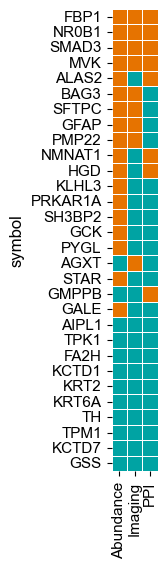

Hit rate: 66.667%


In [14]:
# Sort by row sum (total number of assays passed) - largest to smallest
# First calculate row sums treating NaN as 0 for sorting purposes
row_sums = heatmap_data.fillna(0).sum(axis=1)
sort_order = row_sums.sort_values(ascending=False).index
heatmap_data = heatmap_data.loc[sort_order]

# Create mask AFTER sorting
mask = heatmap_data.isna()

# Convert boolean to int, but keep NaN as NaN initially
heatmap_data_filled = heatmap_data.astype(float)  # Keep as float to preserve NaN

# Create custom colormap: blue for False (0), red for True (1)
colors = ['#00A3A3', '#E67300']  # blue, red
custom_cmap = ListedColormap(colors)

# Set the bad color (for masked values) to light grey
custom_cmap.set_bad(color='lightgrey')

fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.heatmap(heatmap_data_filled, 
            # mask=panel1_mask,
            cmap=custom_cmap, 
            square=True,
            cbar=False,
            linewidths=0.5,
            linecolor='white',
            ax=ax,
            yticklabels=True,
            vmin=0, vmax=1
)
plt.show()

hit_rate = heatmap_data_filled.loc[heatmap_data_filled.sum(axis=1) > 0,:].shape[0] / heatmap_data_filled.shape[0]
print(f"Hit rate: {hit_rate*100:.3f}%")

In [15]:
plt.clf()
# Prepare data for heatmap - handle NaN values properly
heatmap_data = merged_genes_any_path.loc[:,["Passes_Threshold_dualipa", "Passes_Threshold_imaging", "Passes_Threshold"]].rename(
    {
        "Passes_Threshold_dualipa": "Abundance",
        "Passes_Threshold_imaging": "Imaging",
        "Passes_Threshold": "PPI"
    }, axis=1
).copy()

heatmap_data["Row_NA_sum"] = heatmap_data.isna().sum(axis=1)

<Figure size 640x480 with 0 Axes>

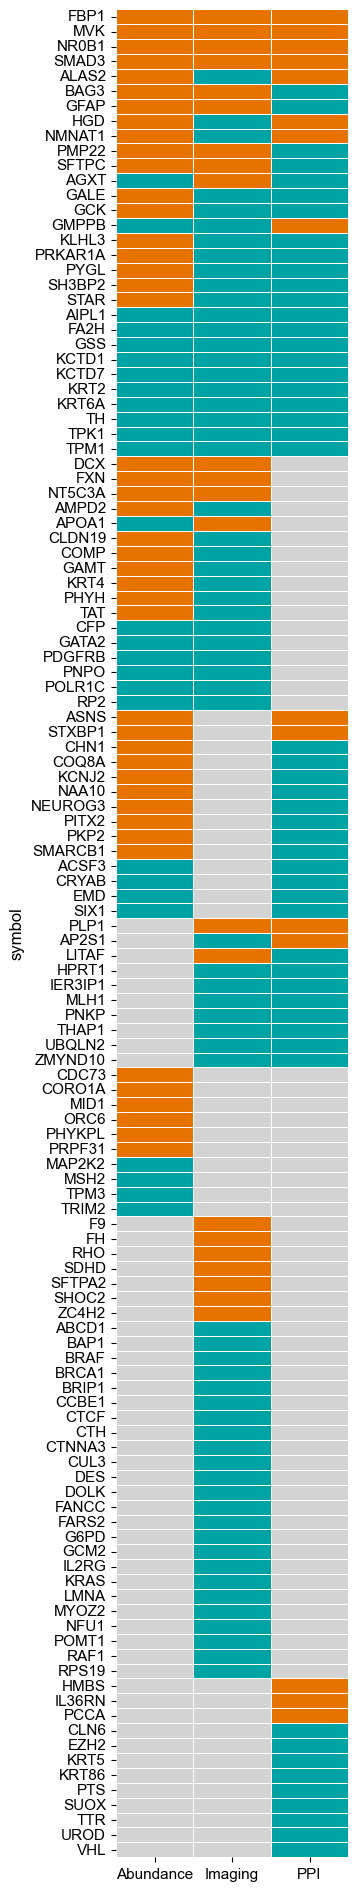

In [60]:
plt.clf()
# Prepare data for heatmap - handle NaN values properly
heatmap_data = merged_genes_any_path.loc[:,["Passes_Threshold_dualipa", "Passes_Threshold_imaging", "Passes_Threshold"]].rename(
    {
        "Passes_Threshold_dualipa": "Abundance",
        "Passes_Threshold_imaging": "Imaging",
        "Passes_Threshold": "PPI"
    }, axis=1
).copy()

heatmap_data["Row_NA_sum"] = heatmap_data.isna().sum(axis=1)
heatmap_data["Row_Sum"] = heatmap_data[["Abundance","Imaging","PPI"]].sum(axis=1)
heatmap_data["Row_Abun"] = heatmap_data[["Abundance"]].isna()
heatmap_data["Row_Img"] = heatmap_data[["Imaging"]].isna()
heatmap_data["Row_PPI"] = heatmap_data[["PPI"]].isna()

heatmap_data["Gene"] = heatmap_data.index

heatmap_data = heatmap_data.sort_values(
    by=["Row_NA_sum", "Row_Abun", "Row_Img", "Row_PPI", "Row_Sum", "Gene"], ##, 
    ascending=[True, True, True, True, False, True]
)

# Create mask AFTER sorting
mask = heatmap_data[["Abundance", "Imaging", "PPI"]].isna()

# Convert boolean to int, but keep NaN as NaN initially
heatmap_data_filled = heatmap_data[["Abundance", "Imaging", "PPI"]].astype(float)  # Keep as float to preserve NaN

# Create custom colormap: blue for False (0), red for True (1)
colors = ['#00A3A3', '#E67300']  # blue, red
custom_cmap = ListedColormap(colors)

# Set the bad color (for masked values) to light grey
custom_cmap.set_bad(color='lightgrey')

fig, ax = plt.subplots(1,1,figsize=(3,24))
sns.heatmap(heatmap_data_filled, 
            # mask=panel1_mask,
            cmap=custom_cmap, 
            # square=True,
            cbar=False,
            linewidths=0.5,
            linecolor='white',
            ax=ax,
            yticklabels=True,
            vmin=0, vmax=1
)
# plt.tight_layout()
fig.savefig(
    f"../3_outputs/pillar_manuscript_figures/assay_hit_per_gene.svg",
    format='svg',
    dpi=400,
    bbox_inches='tight',
    transparent=True
)
plt.show()

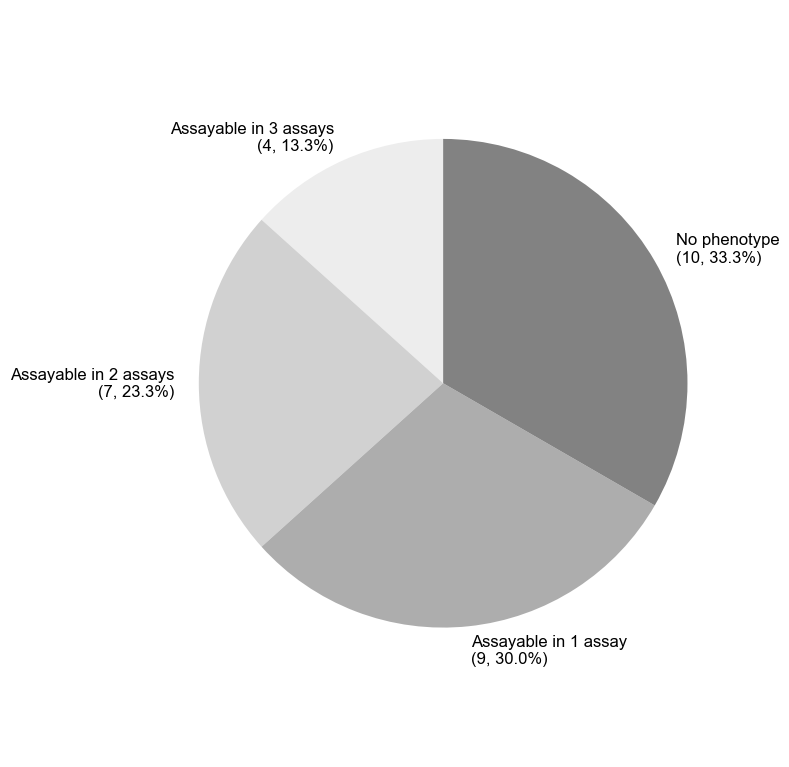

Assayable in 3 assays: 4 genes (13.3%)
Assayable in 2 assays: 7 genes (23.3%)
Assayable in 1 assay: 9 genes (30.0%)
No phenotype: 10 genes (33.3%)

Total genes: 30


In [61]:
# Create pie chart for ClinVar annotation categories
merged_genes_any_path_pl = pl.DataFrame(merged_genes_any_path).with_columns(
    pl.when(pl.col("true_count")==0)
    .then(pl.lit("No phenotype"))
    .when(pl.col("true_count")==1)
    .then(pl.lit("Assayable in 1 assay"))
    .when(pl.col("true_count")==2)
    .then(pl.lit("Assayable in 2 assays"))
    .otherwise(pl.lit("Assayable in 3 assays"))
    .alias("Assayable")
).filter(
    pl.col("non_null_count")==3
)
# Get the category counts from the merged data
summary_clin_var_counts = merged_genes_any_path_pl.group_by("Assayable").len() #.sort("clinvar_clnsig_clean")#.sort("len", descending=True)
summary_clin_var_counts = merged_genes_any_path_pl.group_by("Assayable").len().to_pandas()
category_order = ["Assayable in 3 assays", "Assayable in 2 assays", "Assayable in 1 assay", "No phenotype"]
summary_clin_var_counts['Assayable'] = pd.Categorical(summary_clin_var_counts['Assayable'], categories=category_order, ordered=True)

# Convert to pandas for easier plotting
pie_data = summary_clin_var_counts.sort_values('Assayable')
pie_data = pie_data.dropna()  # Remove any null values

# Calculate percentages
total_count = pie_data["len"].sum()
pie_data["percentage"] = (pie_data["len"] / total_count * 100).round(1)

# Create labels with counts and percentages
labels = [f"{cat}\n({count}, {pct}%)" 
          for cat, count, pct in zip(pie_data["Assayable"], 
                                   pie_data["len"], 
                                   pie_data["percentage"])]

# Use a color palette that matches the boxenplot
# colors = list(palette_dict["clinvar_clnsig_clean"].values())
# colors[1], colors[3] = colors[3], colors[1]  # Swap colors to match the order in pie chart
# Create pie chart
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
wedges, texts, autotexts = ax.pie(pie_data["len"], 
                                  labels=labels, 
                                  colors=sns.color_palette("Greys"),
                                  autopct="",  # We're including percentages in labels
                                  startangle=90,
                                  textprops={'fontsize': 12})

# ax.set_title("Distribution of Molecular Phenotype Detection Rate", y=.90, fontsize=14, fontweight='bold', pad=0)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# # Add a legend
# ax.legend(wedges, [f"{cat} (n={count})" for cat, count in zip(pie_data["clinvar_clnsig_clean"], pie_data["len"])],
#           title="Categories",
#           loc="center left",
#           bbox_to_anchor=(1, 0, 0.5, 1))

plt.tight_layout()
fig.savefig(
    f"../3_outputs/pillar_manuscript_figures/gene_assayability.svg",
    format='svg',
    dpi=400,
    bbox_inches='tight',
    transparent=True
)
plt.show()

# Print summary statistics
print("=" * 40)
for _, row in pie_data.iterrows():
    print(f"{row['Assayable']}: {row['len']} genes ({row['percentage']}%)")
print(f"\nTotal genes: {total_count}")

## 4. Variant-level Analyses

### 4.1 Gene alleles profiled by ALL 3 assays

In [23]:
meta_cols = ["symbol", "gene_variant", "ensembl_gene_id", "spdi", "orf_id", "mut_id", 
             "nt_change", "aa_change", "clinvar_clnsig_clean", "clinvar_clnsig_clean_pp_strict", "gnomAD4.1_joint_AF", "StarStatus",
             "inheritance_pattern", "AlphaMissense_score", "AlphaMissense_rankscore", "AlphaMissense_pred", 
             "ESM1b_score", "ESM1b_rankscore", "ESM1b_pred",
             "plddt_f32", "rsa_f32", "RSA_Category", "pLDDT_Category"]
dualipa_cols = ["dualipa_score", "dualipa_abun_change", "dualipa_abun_chg_dir"]
img_cols = ["imaging_score", "img_pheno_hit"] ## "AUROC_Mean_DNA", "Altered_95th_perc_both_batches_DNA"
ppi_cols = ["ppi_score", "ppi_hit"]

al_dual_img_ppi_key_cols = al_dual_img_ppi_assayed_dedup.select(
    pl.col(meta_cols + dualipa_cols + img_cols + ppi_cols)
)

### 3.2 Gene Alleles Profiled by AT LEAST ONE assay

In [24]:
alleles_prof_one_assay = al_dual_img_ppi_key_cols.filter(
    ~pl.all_horizontal([pl.col(col).is_null() for col in dualipa_cols+img_cols+ppi_cols])
).unique(subset="gene_variant")
alleles_prof_one_assay.shape

(1427, 30)

In [25]:
# palette_dict = {
#     "clinvar_clnsig_clean":{
#         '1_Pathogenic': "#CA7682",
#         '2_Benign': "#1D7AAB",
#         '3_Conflicting': "#E6B1B8", #"grey",
#         '4_VUS': "#A0A0A0",
#         '5_Others': "#A0A0A0"
#         # '6_No_ClinVar'
#     }
# }

# fig, axes = plt.subplots(1,3,figsize=(18,5))
# plot_cat_count_perc(
#     alleles_prof_one_assay,
#     "clinvar_clnsig_clean",
#     title="ClinVar",
#     ax=axes[0],
#     palette=palette_dict["clinvar_clnsig_clean"]
# )
# # axes[0].legend(loc="lower right")
# axes[0].set_title("Genetic Variant ClinVar Info")

# plot_cat_count_perc(
#     alleles_prof_one_assay.unique("symbol"),
#     "inheritance_pattern",
#     title="Inheritance",
#     ax=axes[1],
# )
# axes[1].set_title("Gene-level Inheritance Pattern")

# plot_cat_count_perc(
#     alleles_prof_one_assay,
#     "inheritance_pattern",
#     title="Inheritance",
#     ax=axes[2],
# )
# axes[2].set_title("Variant-level Inheritance Pattern")

# plt.suptitle(f"{alleles_prof_one_assay.unique('gene_variant').shape[0]} Variants from {alleles_prof_one_assay.unique('symbol').shape[0]} Genes Profiled by Any Functional Assay", y=.97, fontsize=14)
# plt.subplots_adjust(wspace=.6)
# plt.show()

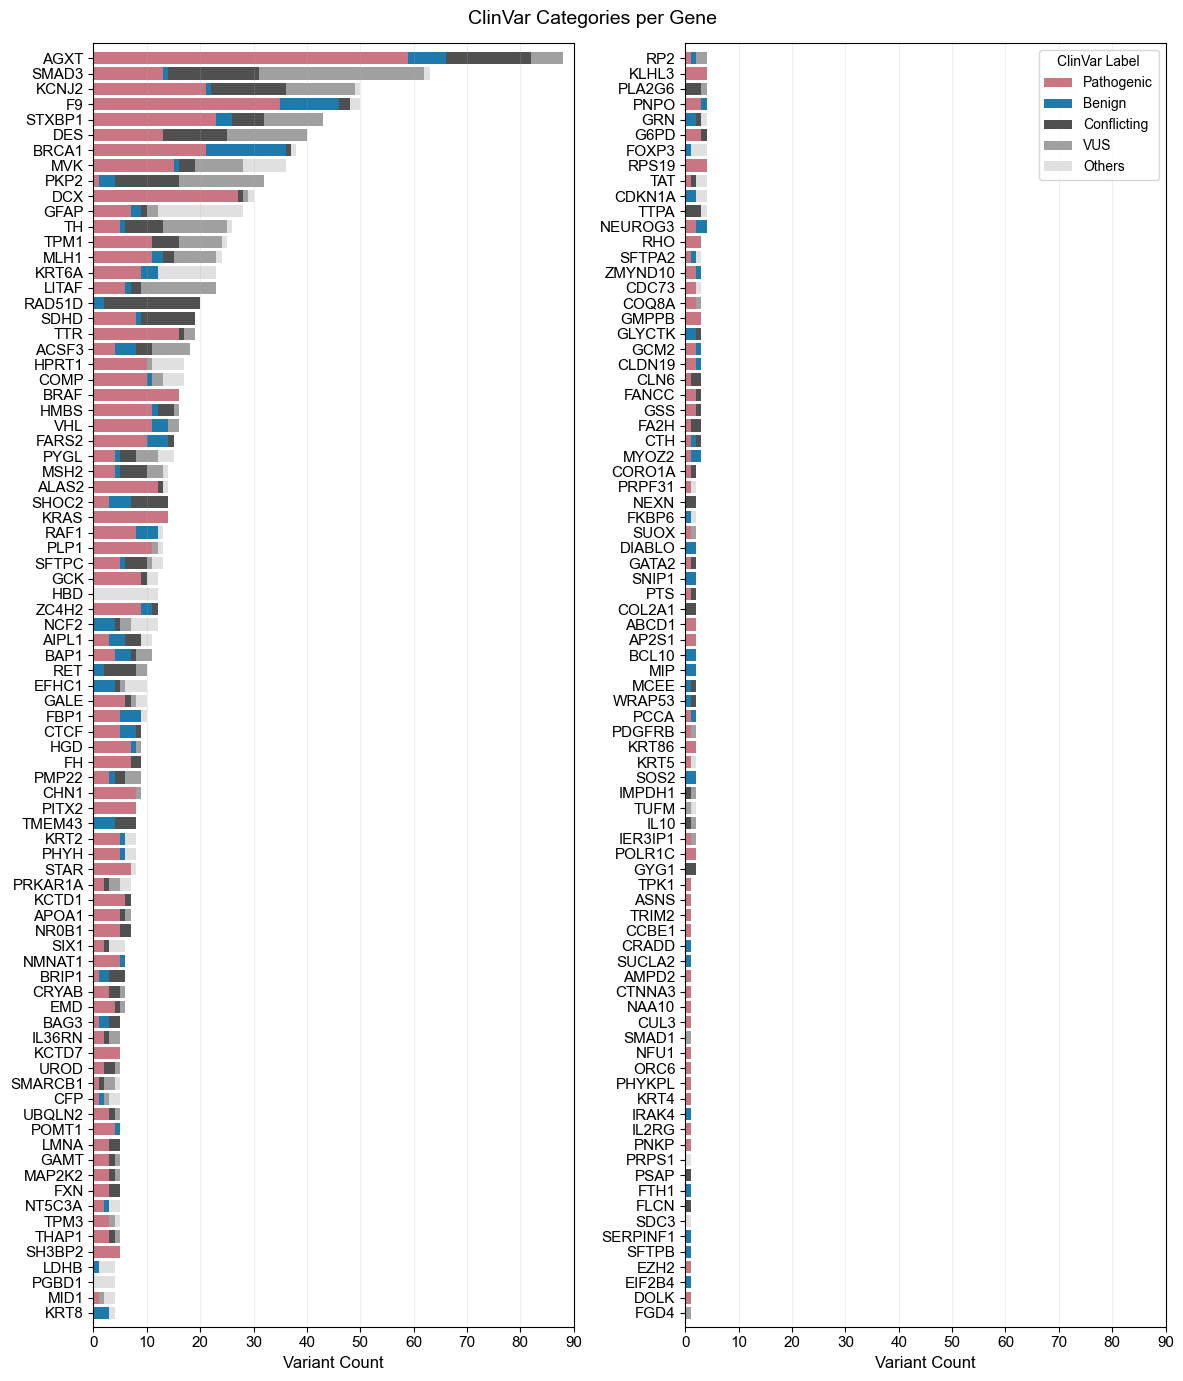

In [54]:
# 2. Count per (gene, category)
df = al_dual_img_ppi_assayed_dedup.to_pandas() ## drop_nulls("clinvar_clnsig_clean").

top_num = int(np.ceil(al_dual_img_ppi_assayed_dedup.unique("symbol").shape[0] / 2))
counts = (
    df.groupby(["symbol", "clinvar_clnsig_clean"])
    .size()
    .reset_index(name="count")
)
# 3. Pivot
pivot = counts.pivot(index="symbol", columns="clinvar_clnsig_clean", values="count").fillna(0)

# Add total count column and sort by it (descending)
pivot["total_count"] = pivot.sum(axis=1)
pivot_top = pivot.sort_values("total_count", ascending=False).head(top_num)
pivot_top = pivot_top.drop(columns=["total_count"])
# category_order = sorted(pivot_top["clinvar_clnsig_clean"].unique())

# # 4. Ensure category order
# for cat in category_order:
#     if cat not in pivot_top.columns:
#         pivot_top[cat] = 0
# pivot_top = pivot_top[category_order]

# 5. Plotting
fig, axes = plt.subplots(1,2, figsize=(12, 14))
# Get Set2 colors
bottom = None
for cat, color in palette_dict["clinvar_clnsig_clean"].items():
    axes[0].barh(pivot_top.index, pivot_top[cat], 
            left=bottom, label=cat, color=color)
    bottom = pivot_top[cat] if bottom is None else bottom + pivot_top[cat]
    
# Axis formatting
axes[0].set_xlabel("Variant Count")
axes[0].set_xlim(None, 90)
axes[0].set_ylim(-1, pivot_top.shape[0] - .1)  # Tighten y-axis to remove top/bottom gaps
# axes[0].set_title(f"ClinVar Categories per Gene (Top {top_num} with Most Variants)", fontsize=14)
axes[0].invert_yaxis()
axes[0].grid(alpha=.2, axis="x")

# ax.legend(title="ClinVar Label", fontsize=9, title_fontsize=10, loc="lower right")
# plt.tight_layout()
# plt.show()

pivot_bot = pivot.sort_values("total_count", ascending=False).iloc[top_num:,].copy()
pivot_bot = pivot_bot.drop(columns=["total_count"])

# 4. Ensure category order
# for cat in category_order:
#     if cat not in pivot_bot.columns:
#         pivot_bot[cat] = 0
# pivot_bot = pivot_bot[category_order]

bottom = None
for cat, color in palette_dict["clinvar_clnsig_clean"].items():
    axes[1].barh(pivot_bot.index, pivot_bot[cat], left=bottom, label=cat, color=color)
    bottom = pivot_bot[cat] if bottom is None else bottom + pivot_bot[cat]
    
# Axis formatting
axes[1].set_xlabel("Variant Count")
axes[1].set_xlim(None, 90)
axes[1].set_ylim(-1, pivot_bot.shape[0] - .1)  # Tighten y-axis to remove top/bottom gaps
# axes[1].set_title(f"ClinVar Categories per Gene ({top_num} After)", fontsize=14)
axes[1].invert_yaxis()
axes[1].legend(title="ClinVar Label", fontsize=10, title_fontsize=10, loc="upper right")
axes[1].grid(alpha=.2, axis="x")
plt.suptitle(f"ClinVar Categories per Gene", fontsize=14, y=.985)
plt.tight_layout()
plt.show()

In [27]:
# # Create pie chart for ClinVar annotation categories
# fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# # Get the category counts from the merged data
# summary_clin_var_counts = alleles_prof_one_assay.group_by("clinvar_clnsig_clean").len() #.sort("clinvar_clnsig_clean")#.sort("len", descending=True)
# summary_clin_var_counts = alleles_prof_one_assay.group_by("clinvar_clnsig_clean").len().to_pandas()
# category_order = ["1_Pathogenic", "2_Benign", "3_Conflicting", "4_VUS", "5_Others"]
# summary_clin_var_counts['clinvar_clnsig_clean'] = pd.Categorical(summary_clin_var_counts['clinvar_clnsig_clean'], categories=category_order, ordered=True)

# # Convert to pandas for easier plotting
# pie_data = summary_clin_var_counts.sort_values('clinvar_clnsig_clean')
# pie_data = pie_data.dropna()  # Remove any null values

# # Calculate percentages
# total_count = pie_data["len"].sum()
# pie_data["percentage"] = (pie_data["len"] / total_count * 100).round(1)

# # Create labels with counts and percentages
# labels = [f"{cat.split('_')[1]}\n({count}, {pct}%)" 
#           for cat, count, pct in zip(pie_data["clinvar_clnsig_clean"], 
#                                    pie_data["len"], 
#                                    pie_data["percentage"])]

# # Use a color palette that matches the boxenplot
# colors = list(palette_dict["clinvar_clnsig_clean"].values())
# # colors[1], colors[3] = colors[3], colors[1]  # Swap colors to match the order in pie chart
# # Create pie chart
# wedges, texts, autotexts = ax.pie(pie_data["len"], 
#                                   labels=labels, 
#                                   colors=colors,
#                                   autopct="",  # We're including percentages in labels
#                                   startangle=90,
#                                   textprops={'fontsize': 12})

# ax.set_title("Distribution of ClinVar Annotation Categories", fontsize=14, fontweight='bold', pad=20)

# # Equal aspect ratio ensures that pie is drawn as a circle
# ax.axis('equal')

# # # Add a legend
# # ax.legend(wedges, [f"{cat} (n={count})" for cat, count in zip(pie_data["clinvar_clnsig_clean"], pie_data["len"])],
# #           title="Categories",
# #           loc="center left",
# #           bbox_to_anchor=(1, 0, 0.5, 1))

# plt.tight_layout()
# plt.show()

# # Print summary statistics
# print("ClinVar Annotation Distribution:")
# print("=" * 40)
# for _, row in pie_data.iterrows():
#     print(f"{row['clinvar_clnsig_clean']}: {row['len']} variants ({row['percentage']}%)")
# print(f"\nTotal variants: {total_count}")

In [49]:
def plot_assay_hit_by_category_perc(df, hit_col, cat_cols, title="", ax=None):
    """
    plot_assay_hit_by_category
    ==========================
    
    Create a stacked horizontal bar chart showing hit rate percentage per category.
    Each bar represents 100% of the category, with the hit portion highlighted.
    
    Parameters
    ----------
    df : polars.DataFrame
        Input table containing at least the columns listed in `cat_cols` and a
        boolean column indicating hits.
    hit_col : str
        Name of the boolean column that flags hits (e.g. `"is_hit"`).
    cat_cols : str or list[str]
        Column(s) that define the categorical grouping(s).  If a single string is
        supplied it is handled automatically.
    title : str, optional
        Title placed above the plot.
    ax : matplotlib.axes.Axes, optional
        Pre-existing axes to draw on.  If None, a new figure and axes are created.
    
    Returns
    -------
    polars.DataFrame
        A tidy frame with one row per category, containing:
            - the grouping key(s)
            - total_counts   : total observations in that category
            - hit_counts     : observations that were hits
            - hit_perc       : hit rate in percent (hit_counts / total_counts * 100)
    """
    # --- compute hit counts and percentages ---
    df_tot_cnt_per_cat = (
        df.group_by(cat_cols)
        .len()
        .rename({"len": "total_counts"})
    )
    df_hit_cnt_per_cat = (
        df.unique("gene_variant")
        .filter(pl.col(hit_col))
        .group_by(cat_cols)
        .len()
        .rename({"len": "hit_counts"})
    )

    cat_col_name = cat_cols if isinstance(cat_cols, str) else cat_cols[-1]
    
    img_hits_perc_df = (
        df_tot_cnt_per_cat.join(
            df_hit_cnt_per_cat,
            on=cat_cols,
            how="left"
        )
        .fill_null(0)
        .with_columns(
            (pl.col("hit_counts") / pl.col("total_counts") * 100).alias("hit_perc")
        )
        .sort(cat_col_name, descending=True)
    )

    # --- plotting ---
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(5, img_hits_perc_df.shape[0]))

    plot_df = img_hits_perc_df.to_pandas()
    y_positions = range(len(plot_df))

    # background bars (full 100% - gray)
    # ax.barh(y_positions, [100] * len(plot_df), color='#00A3A3', label="Non-hit")
    # hit bars (foreground - red)
    ax.barh(y_positions, plot_df["hit_perc"], 
            color=[palette_dict["clinvar_clnsig_clean"]["Pathogenic"],
            palette_dict["clinvar_clnsig_clean"]["Benign"],
            ], label="Hit")

    # set labels
    ax.set_yticks(y_positions)
    ax.set_yticklabels([f"{cat}\n(n={n})" for cat, n in zip(plot_df[cat_col_name], plot_df["total_counts"])]) ##.split('_')[1]
    ax.set_xlabel("Percentage (%)")
    ax.set_xlim(0, 100)
    ax.set_title(title)
    ax.grid(axis='x', alpha=.2)
    # ax.legend(loc='lower right')

    # percentage annotations - positioned at the end of hit bar
    for idx, row in plot_df.iterrows():
        ax.text(
            row["hit_perc"] + 1,
            idx,
            f"{row['hit_perc']:.1f}%",
            va="center",
            ha="left",
            fontweight="bold",
            fontsize=11,
            color="black"
        )
    return img_hits_perc_df

In [50]:
contingency_table = al_dual_img_ppi_assayed_dedup.with_columns(
    pl.when((pl.col("dualipa_abun_change")=="Y") | (pl.col("imaging_hit")) | (pl.col("ppi_hit")))
    .then(pl.lit(True))
    .otherwise(pl.lit(False))
    .alias("any_assay_hit")
).group_by(
    ["any_assay_hit", 'clinvar_clnsig_clean']
).agg(
    pl.len()
).pivot(
    index="any_assay_hit",
    on='clinvar_clnsig_clean',
    values="len"
).sort(
    "any_assay_hit", descending=True
)
print(
    contingency_table.select(
        (pl.col("Pathogenic").first() / pl.col("Pathogenic").sum()).alias("Pathogenic_hit_rate"),
        (pl.col("Benign").first() / pl.col("Benign").sum()).alias("Benign_hit_rate")
    )
)
table = contingency_table.select(["Pathogenic", "Benign"]).to_numpy()  # Flip so true is first row
odds_ratio, p_value = fisher_exact(table, alternative='two-sided')

print(p_value)

shape: (1, 2)
┌─────────────────────┬─────────────────┐
│ Pathogenic_hit_rate ┆ Benign_hit_rate │
│ ---                 ┆ ---             │
│ f64                 ┆ f64             │
╞═════════════════════╪═════════════════╡
│ 0.310751            ┆ 0.08642         │
└─────────────────────┴─────────────────┘
4.567974304437269e-10


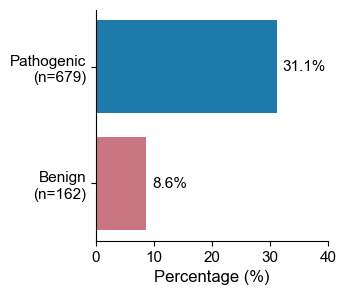

In [62]:
fig, axes = plt.subplots(1,1,figsize=(3,3), sharey=False)
# plot_cat_count_perc(
#     alleles_prof_one_assay.with_columns(
#         pl.col("clinvar_clnsig_clean")
#             .cast(pl.Enum([c for c in clinvar_order_dict["original"] if "Likely" not in c]))
#     ).sort("clinvar_clnsig_clean"),
#     "clinvar_clnsig_clean",
#     title="ClinVar",
#     ax=axes[1],
#     palette=palette_dict["clinvar_clnsig_clean"]
# )
# axes[1].set_title("Genetic Variant ClinVar Distribution")
# axes[1].set_xlabel("Count")
# axes[1].set_ylabel("")
# axes[1].set_yticklabels("")
# axes[1].grid(alpha=.2)

plot_assay_hit_by_category_perc(
    alleles_prof_one_assay.with_columns(
        pl.col("clinvar_clnsig_clean")
            .cast(pl.Enum([c for c in clinvar_order_dict["original"] if "Likely" not in c]))
    ).sort("clinvar_clnsig_clean").filter(
        pl.col("clinvar_clnsig_clean").is_in(["Pathogenic", "Benign"])
    ), 
    # .with_columns(
    #     pl.col("clinvar_clnsig_clean").replace(
    #         {"Pathogenic": "PLP", "Benign": "BLB"}
    #     ).alias("clinvar_clnsig_clean")
    # )
    "any_assay_hit", 
    "clinvar_clnsig_clean", 
    f"", 
    ax=axes
)
axes.set_xlabel("Percentage (%)")
axes.set_xlim(0,40)
axes.grid(alpha=.0)
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)

# plt.suptitle(f"{alleles_prof_one_assay.unique('gene_variant').shape[0]} Variants from {alleles_prof_one_assay.unique('symbol').shape[0]} Genes Profiled by Any Functional Assay", y=.99, fontsize=12)
plt.subplots_adjust(wspace=.05)
fig.savefig(
    f"../3_outputs/pillar_manuscript_figures/PLP_BLB_hits.svg",
    format='svg',
    dpi=400,
    bbox_inches='tight',
    transparent=True
)
plt.show()